### HW3 part A by Denis Osipychev
##### import gym and local environments

In [1]:
import gym, myenv, time
import numpy as np
import matplotlib.pyplot as plt
import random
#dir(myenv)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[ 0.05177147  1.40105628 -0.77006235 -0.12515677]


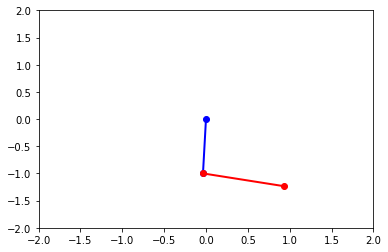

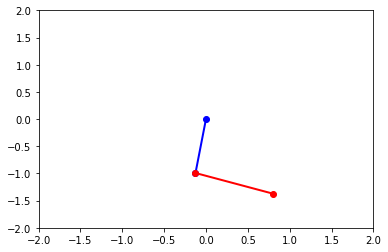

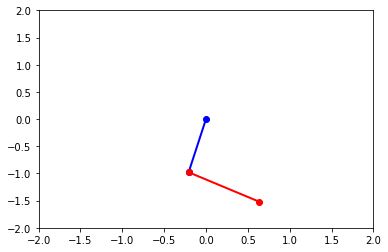

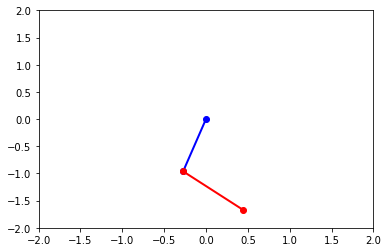

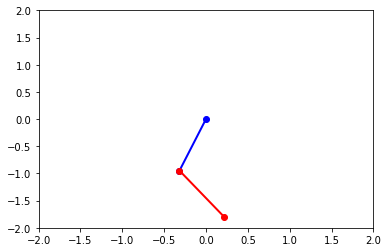

In [2]:
# initialize the env and test it with a fixed action
env = myenv.AcrobotEnv()
print(env.reset())
for i in range(5):
    action = 1
    s,r,d,_ = env.step(action)
    env.render()

In [16]:
# initialize hyperparameters
n_episodes = 100000
episode_lenght = 100
gamma = 0.99
alpha = 0.01
epsilon = 1 # it will vary during the training
n_actions = 3
batch_size = 100

In [17]:
# import and initialize the TF q network
import tensorflow as tf
import tensorflow.contrib.slim as slim

class Qnetwork():
    def __init__(self):
        
        self.input = tf.placeholder(shape=[None,4],dtype=tf.float32)
        hidden = slim.fully_connected(self.input,256,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,n_actions,activation_fn=tf.nn.softmax,biases_initializer=None)
        
        self.new_q = tf.placeholder(shape=[None,n_actions],dtype=tf.float32)
        
        self.loss = tf.reduce_sum(tf.square(self.new_q - self.output))
        optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
        self.update_model = optimizer.minimize(self.loss)

In [18]:
class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
# epsilon greedy policy
def greedy_policy(Q):
    if np.random.uniform() < epsilon:
        best_action = np.random.randint(n_actions)
    else:
        best_action = np.argmax(Q)
    return best_action

In [20]:
# initialize the weights and network
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = Qnetwork()
merged = tf.summary.merge_all()

memory = ReplayMemory(1000)

In [21]:
# launch the session
sess = tf.Session()

# initialize, save or restore the network 
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

INFO:tensorflow:Restoring parameters from ./model/ctf_policy.ckpt
Load Model :  ./model/ctf_policy.ckpt


In [ ]:
history = []
i = 0

# run the training
while i < n_episodes:
    
    s = env.reset()
    total_reward = 0
    i += 1
    j = 0
    d = False
    experience = []
    
    #run the simulation
    while j < episode_lenght:
        
        j += 1
        
        q = sess.run(myAgent.output,feed_dict={myAgent.input:np.reshape(s,[1,4])})
        action = greedy_policy(q)
        
        # do the step
        s_new,r,d,_ = env.step(action)
        
        q_next = sess.run(myAgent.output,feed_dict={myAgent.input:[s_new]})
        targetq = q.flatten()
        targetq[action] = r + gamma * np.max(q_next)
        
        memory.push([s,targetq])
        
        total_reward += r
        s = s_new
        
#         if d == True:
#             break
    
    # update q
    #if d == True:
    st, qt = zip(*memory.sample(batch_size))
    _ = sess.run(myAgent.update_model,feed_dict={myAgent.input:st,
                                                 myAgent.new_q:qt})
    # decay exploration
    epsilon = epsilon * 0.99995
    
    history.append([i, total_reward, epsilon, alpha])
    
    if i % 100 == 0:
        # save the model
        print(' Average r :', np.mean(np.asarray(history)[-100:,1]))
        saver.save(sess, './model/ctf_policy.ckpt')

 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.01
 Average r : 0.01
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.01
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.01
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.01
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0
 Average r : 0.0


In [ ]:
# plot the history
h = np.asarray(history)
plt.subplot(3, 1, 1)
plt.plot(h[:,0], h[:,1], 'o-')
plt.ylabel('reward')

plt.subplot(3, 1, 2)
plt.plot(h[:,0], h[:,2], '.-')
plt.xlabel('step')
plt.ylabel('epsilon')

plt.subplot(3, 1, 3)
plt.plot(h[:,0], h[:,3], '.-')
plt.xlabel('step')
plt.ylabel('alpha')

plt.show()

In [ ]:
ckpt = tf.train.get_checkpoint_state('./model')

if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    print("No policy for evaluation")

# evaluate the policy
s = env.reset()
total_reward = 0
j = 0

while j < episode_lenght:
    j += 1
    q = sess.run(myAgent.output,feed_dict={myAgent.input:np.reshape(s,[1,4])})
    action = np.argmax(q)
    s_new,r,d,_ = env.step(action)
    total_reward += r
    s = s_new
    env.render()
    print(r)
print("total reward:", total_reward)

## Results:

The agent learned to do the swing motion, but the it cannot gain enough momentum.
There might be two reasons: 
<li>not enought force, so it cannot gain the momentum to flip the pendulum.
<li>not enough training, so the agent does not know the exact state when to change the force direction.